In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "0:1:2:3:4"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                     | 0/50000 [00:00<?, ?it/s]

  9%|███████▌                                                                               | 4352/50000 [00:00<00:01, 43514.85it/s]

 18%|███████████████▏                                                                       | 8752/50000 [00:00<00:00, 43799.32it/s]

 26%|██████████████████████▋                                                               | 13159/50000 [00:00<00:00, 43919.73it/s]

 35%|██████████████████████████████▏                                                       | 17565/50000 [00:00<00:00, 43973.51it/s]

 44%|█████████████████████████████████████▊                                                | 21983/50000 [00:00<00:00, 44044.16it/s]

 53%|█████████████████████████████████████████████▍                                        | 26409/50000 [00:00<00:00, 44115.69it/s]

 62%|█████████████████████████████████████████████████████                                 | 30829/50000 [00:00<00:00, 44140.31it/s]

 71%|████████████████████████████████████████████████████████████▋                         | 35252/50000 [00:00<00:00, 44166.22it/s]

 79%|████████████████████████████████████████████████████████████████████▏                 | 39677/50000 [00:00<00:00, 44189.72it/s]

 88%|███████████████████████████████████████████████████████████████████████████▊          | 44096/50000 [00:01<00:00, 44172.27it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▍  | 48519/50000 [00:01<00:00, 44187.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 44056.72it/s]

Files already downloaded and verified


  0%|                                                                                                     | 0/10000 [00:00<?, ?it/s]

 44%|██████████████████████████████████████                                                 | 4381/10000 [00:00<00:00, 43802.10it/s]

 88%|████████████████████████████████████████████████████████████████████████████▍          | 8788/10000 [00:00<00:00, 43954.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 43883.76it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1:2:3:4 pnigdeyr


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-pnigdeyr:best, 58.53MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                       | 0/157 [00:00<?, ?it/s]

  1%|▌                                                                                              | 1/157 [00:00<01:25,  1.83it/s]

  2%|█▊                                                                                             | 3/157 [00:00<00:30,  5.03it/s]

  3%|███                                                                                            | 5/157 [00:00<00:19,  7.68it/s]

  4%|████▏                                                                                          | 7/157 [00:00<00:15,  9.76it/s]

  6%|█████▍                                                                                         | 9/157 [00:01<00:13, 11.32it/s]

  7%|██████▌                                                                                       | 11/157 [00:01<00:11, 12.48it/s]

  8%|███████▊                                                                                      | 13/157 [00:01<00:10, 13.32it/s]

 10%|████████▉                                                                                     | 15/157 [00:01<00:10, 13.92it/s]

 11%|██████████▏                                                                                   | 17/157 [00:01<00:09, 14.36it/s]

 12%|███████████▍                                                                                  | 19/157 [00:01<00:09, 14.67it/s]

 13%|████████████▌                                                                                 | 21/157 [00:01<00:09, 14.89it/s]

 15%|█████████████▊                                                                                | 23/157 [00:01<00:08, 15.04it/s]

 16%|██████████████▉                                                                               | 25/157 [00:02<00:08, 15.15it/s]

 17%|████████████████▏                                                                             | 27/157 [00:02<00:08, 15.23it/s]

 18%|█████████████████▎                                                                            | 29/157 [00:02<00:08, 15.28it/s]

 20%|██████████████████▌                                                                           | 31/157 [00:02<00:08, 15.32it/s]

 21%|███████████████████▊                                                                          | 33/157 [00:02<00:08, 15.35it/s]

 22%|████████████████████▉                                                                         | 35/157 [00:02<00:07, 15.37it/s]

 24%|██████████████████████▏                                                                       | 37/157 [00:02<00:07, 15.39it/s]

 25%|███████████████████████▎                                                                      | 39/157 [00:03<00:07, 15.39it/s]

 26%|████████████████████████▌                                                                     | 41/157 [00:03<00:07, 15.40it/s]

 27%|█████████████████████████▋                                                                    | 43/157 [00:03<00:07, 15.40it/s]

 29%|██████████████████████████▉                                                                   | 45/157 [00:03<00:07, 15.40it/s]

 30%|████████████████████████████▏                                                                 | 47/157 [00:03<00:07, 15.40it/s]

 31%|█████████████████████████████▎                                                                | 49/157 [00:03<00:07, 15.40it/s]

 32%|██████████████████████████████▌                                                               | 51/157 [00:03<00:06, 15.40it/s]

 34%|███████████████████████████████▋                                                              | 53/157 [00:03<00:06, 15.41it/s]

 35%|████████████████████████████████▉                                                             | 55/157 [00:04<00:06, 15.41it/s]

 36%|██████████████████████████████████▏                                                           | 57/157 [00:04<00:06, 15.40it/s]

 38%|███████████████████████████████████▎                                                          | 59/157 [00:04<00:06, 15.41it/s]

 39%|████████████████████████████████████▌                                                         | 61/157 [00:04<00:06, 15.41it/s]

 40%|█████████████████████████████████████▋                                                        | 63/157 [00:04<00:06, 15.41it/s]

 41%|██████████████████████████████████████▉                                                       | 65/157 [00:04<00:05, 15.41it/s]

 43%|████████████████████████████████████████                                                      | 67/157 [00:04<00:05, 15.41it/s]

 44%|█████████████████████████████████████████▎                                                    | 69/157 [00:04<00:05, 15.42it/s]

 45%|██████████████████████████████████████████▌                                                   | 71/157 [00:05<00:05, 15.41it/s]

 46%|███████████████████████████████████████████▋                                                  | 73/157 [00:05<00:05, 15.40it/s]

 48%|████████████████████████████████████████████▉                                                 | 75/157 [00:05<00:05, 15.39it/s]

 49%|██████████████████████████████████████████████                                                | 77/157 [00:05<00:05, 15.40it/s]

 50%|███████████████████████████████████████████████▎                                              | 79/157 [00:05<00:05, 15.41it/s]

 52%|████████████████████████████████████████████████▍                                             | 81/157 [00:05<00:04, 15.41it/s]

 53%|█████████████████████████████████████████████████▋                                            | 83/157 [00:05<00:04, 15.40it/s]

 54%|██████████████████████████████████████████████████▉                                           | 85/157 [00:06<00:04, 15.41it/s]

 55%|████████████████████████████████████████████████████                                          | 87/157 [00:06<00:04, 15.41it/s]

 57%|█████████████████████████████████████████████████████▎                                        | 89/157 [00:06<00:04, 15.42it/s]

 58%|██████████████████████████████████████████████████████▍                                       | 91/157 [00:06<00:04, 15.41it/s]

 59%|███████████████████████████████████████████████████████▋                                      | 93/157 [00:06<00:04, 15.41it/s]

 61%|████████████████████████████████████████████████████████▉                                     | 95/157 [00:06<00:04, 15.40it/s]

 62%|██████████████████████████████████████████████████████████                                    | 97/157 [00:06<00:03, 15.40it/s]

 63%|███████████████████████████████████████████████████████████▎                                  | 99/157 [00:06<00:03, 15.40it/s]

 64%|███████████████████████████████████████████████████████████▊                                 | 101/157 [00:07<00:03, 15.39it/s]

 66%|█████████████████████████████████████████████████████████████                                | 103/157 [00:07<00:03, 15.40it/s]

 67%|██████████████████████████████████████████████████████████████▏                              | 105/157 [00:07<00:03, 15.40it/s]

 68%|███████████████████████████████████████████████████████████████▍                             | 107/157 [00:07<00:03, 15.39it/s]

 69%|████████████████████████████████████████████████████████████████▌                            | 109/157 [00:07<00:03, 15.39it/s]

 71%|█████████████████████████████████████████████████████████████████▊                           | 111/157 [00:07<00:02, 15.40it/s]

 72%|██████████████████████████████████████████████████████████████████▉                          | 113/157 [00:07<00:02, 15.40it/s]

 73%|████████████████████████████████████████████████████████████████████                         | 115/157 [00:07<00:02, 15.40it/s]

 75%|█████████████████████████████████████████████████████████████████████▎                       | 117/157 [00:08<00:02, 15.40it/s]

 76%|██████████████████████████████████████████████████████████████████████▍                      | 119/157 [00:08<00:02, 15.41it/s]

 77%|███████████████████████████████████████████████████████████████████████▋                     | 121/157 [00:08<00:02, 15.39it/s]

 78%|████████████████████████████████████████████████████████████████████████▊                    | 123/157 [00:08<00:02, 15.40it/s]

 80%|██████████████████████████████████████████████████████████████████████████                   | 125/157 [00:08<00:02, 15.40it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 127/157 [00:08<00:01, 15.37it/s]

 82%|████████████████████████████████████████████████████████████████████████████▍                | 129/157 [00:08<00:01, 15.38it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▌               | 131/157 [00:09<00:01, 15.39it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▊              | 133/157 [00:09<00:01, 15.41it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▉             | 135/157 [00:09<00:01, 15.42it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 137/157 [00:09<00:01, 15.41it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▎          | 139/157 [00:09<00:01, 15.42it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▌         | 141/157 [00:09<00:01, 15.42it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▋        | 143/157 [00:09<00:00, 15.42it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▉       | 145/157 [00:09<00:00, 15.42it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████      | 147/157 [00:10<00:00, 15.42it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 149/157 [00:10<00:00, 15.40it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▍   | 151/157 [00:10<00:00, 15.41it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▋  | 153/157 [00:10<00:00, 15.42it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 155/157 [00:10<00:00, 15.41it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 15.39it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.65it/s]

train - OK


  0%|                                                                                                        | 0/40 [00:00<?, ?it/s]

  2%|██▍                                                                                             | 1/40 [00:00<00:06,  5.85it/s]

  8%|███████▏                                                                                        | 3/40 [00:00<00:03, 10.76it/s]

 12%|████████████                                                                                    | 5/40 [00:00<00:02, 12.72it/s]

 18%|████████████████▊                                                                               | 7/40 [00:00<00:02, 13.74it/s]

 22%|█████████████████████▌                                                                          | 9/40 [00:00<00:02, 14.32it/s]

 28%|██████████████████████████▏                                                                    | 11/40 [00:00<00:01, 14.68it/s]

 32%|██████████████████████████████▉                                                                | 13/40 [00:00<00:01, 14.91it/s]

 38%|███████████████████████████████████▋                                                           | 15/40 [00:01<00:01, 15.06it/s]

 42%|████████████████████████████████████████▍                                                      | 17/40 [00:01<00:01, 15.17it/s]

 48%|█████████████████████████████████████████████▏                                                 | 19/40 [00:01<00:01, 15.23it/s]

 52%|█████████████████████████████████████████████████▉                                             | 21/40 [00:01<00:01, 15.28it/s]

 57%|██████████████████████████████████████████████████████▌                                        | 23/40 [00:01<00:01, 15.32it/s]

 62%|███████████████████████████████████████████████████████████▍                                   | 25/40 [00:01<00:00, 15.25it/s]

 68%|████████████████████████████████████████████████████████████████▏                              | 27/40 [00:01<00:00, 15.29it/s]

 72%|████████████████████████████████████████████████████████████████████▉                          | 29/40 [00:01<00:00, 15.32it/s]

 78%|█████████████████████████████████████████████████████████████████████████▋                     | 31/40 [00:02<00:00, 15.34it/s]

 82%|██████████████████████████████████████████████████████████████████████████████▍                | 33/40 [00:02<00:00, 15.35it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▏           | 35/40 [00:02<00:00, 15.37it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████▉       | 37/40 [00:02<00:00, 15.38it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████▋  | 39/40 [00:02<00:00, 15.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.58it/s]

val - OK


  0%|                                                                                                        | 0/40 [00:00<?, ?it/s]

  2%|██▍                                                                                             | 1/40 [00:00<00:06,  6.04it/s]

  8%|███████▏                                                                                        | 3/40 [00:00<00:03, 10.95it/s]

 12%|████████████                                                                                    | 5/40 [00:00<00:02, 12.85it/s]

 18%|████████████████▊                                                                               | 7/40 [00:00<00:02, 13.82it/s]

 22%|█████████████████████▌                                                                          | 9/40 [00:00<00:02, 14.37it/s]

 28%|██████████████████████████▏                                                                    | 11/40 [00:00<00:01, 14.71it/s]

 32%|██████████████████████████████▉                                                                | 13/40 [00:00<00:01, 14.93it/s]

 38%|███████████████████████████████████▋                                                           | 15/40 [00:01<00:01, 15.07it/s]

 42%|████████████████████████████████████████▍                                                      | 17/40 [00:01<00:01, 15.17it/s]

 48%|█████████████████████████████████████████████▏                                                 | 19/40 [00:01<00:01, 15.24it/s]

 52%|█████████████████████████████████████████████████▉                                             | 21/40 [00:01<00:01, 15.29it/s]

 57%|██████████████████████████████████████████████████████▌                                        | 23/40 [00:01<00:01, 15.32it/s]

 62%|███████████████████████████████████████████████████████████▍                                   | 25/40 [00:01<00:00, 15.34it/s]

 68%|████████████████████████████████████████████████████████████████▏                              | 27/40 [00:01<00:00, 15.36it/s]

 72%|████████████████████████████████████████████████████████████████████▉                          | 29/40 [00:01<00:00, 15.36it/s]

 78%|█████████████████████████████████████████████████████████████████████████▋                     | 31/40 [00:02<00:00, 15.37it/s]

 82%|██████████████████████████████████████████████████████████████████████████████▍                | 33/40 [00:02<00:00, 15.37it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▏           | 35/40 [00:02<00:00, 15.38it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████▉       | 37/40 [00:02<00:00, 15.39it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████▋  | 39/40 [00:02<00:00, 15.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.80it/s]

test InD - OK


  0%|                                                                                                       | 0/235 [00:00<?, ?it/s]

  0%|▍                                                                                              | 1/235 [00:00<00:42,  5.52it/s]

  1%|█▏                                                                                             | 3/235 [00:00<00:22, 10.48it/s]

  2%|██                                                                                             | 5/235 [00:00<00:18, 12.54it/s]

  3%|██▊                                                                                            | 7/235 [00:00<00:16, 13.61it/s]

  4%|███▋                                                                                           | 9/235 [00:00<00:15, 14.24it/s]

  5%|████▍                                                                                         | 11/235 [00:00<00:15, 14.63it/s]

  6%|█████▏                                                                                        | 13/235 [00:00<00:14, 14.88it/s]

  6%|█████▉                                                                                        | 15/235 [00:01<00:14, 15.05it/s]

  7%|██████▊                                                                                       | 17/235 [00:01<00:14, 15.16it/s]

  8%|███████▌                                                                                      | 19/235 [00:01<00:14, 15.24it/s]

  9%|████████▍                                                                                     | 21/235 [00:01<00:13, 15.29it/s]

 10%|█████████▏                                                                                    | 23/235 [00:01<00:13, 15.33it/s]

 11%|██████████                                                                                    | 25/235 [00:01<00:13, 15.35it/s]

 11%|██████████▊                                                                                   | 27/235 [00:01<00:13, 15.37it/s]

 12%|███████████▌                                                                                  | 29/235 [00:01<00:13, 15.39it/s]

 13%|████████████▍                                                                                 | 31/235 [00:02<00:13, 15.40it/s]

 14%|█████████████▏                                                                                | 33/235 [00:02<00:13, 15.40it/s]

 15%|██████████████                                                                                | 35/235 [00:02<00:12, 15.40it/s]

 16%|██████████████▊                                                                               | 37/235 [00:02<00:12, 15.38it/s]

 17%|███████████████▌                                                                              | 39/235 [00:02<00:12, 15.39it/s]

 17%|████████████████▍                                                                             | 41/235 [00:02<00:12, 15.40it/s]

 18%|█████████████████▏                                                                            | 43/235 [00:02<00:12, 15.40it/s]

 19%|██████████████████                                                                            | 45/235 [00:03<00:12, 15.41it/s]

 20%|██████████████████▊                                                                           | 47/235 [00:03<00:12, 15.41it/s]

 21%|███████████████████▌                                                                          | 49/235 [00:03<00:12, 15.41it/s]

 22%|████████████████████▍                                                                         | 51/235 [00:03<00:11, 15.41it/s]

 23%|█████████████████████▏                                                                        | 53/235 [00:03<00:11, 15.41it/s]

 23%|██████████████████████                                                                        | 55/235 [00:03<00:11, 15.41it/s]

 24%|██████████████████████▊                                                                       | 57/235 [00:03<00:11, 15.41it/s]

 25%|███████████████████████▌                                                                      | 59/235 [00:03<00:11, 15.41it/s]

 26%|████████████████████████▍                                                                     | 61/235 [00:04<00:11, 15.42it/s]

 27%|█████████████████████████▏                                                                    | 63/235 [00:04<00:11, 15.42it/s]

 28%|██████████████████████████                                                                    | 65/235 [00:04<00:11, 15.41it/s]

 29%|██████████████████████████▊                                                                   | 67/235 [00:04<00:10, 15.41it/s]

 29%|███████████████████████████▌                                                                  | 69/235 [00:04<00:10, 15.41it/s]

 30%|████████████████████████████▍                                                                 | 71/235 [00:04<00:10, 15.41it/s]

 31%|█████████████████████████████▏                                                                | 73/235 [00:04<00:10, 15.41it/s]

 32%|██████████████████████████████                                                                | 75/235 [00:04<00:10, 15.41it/s]

 33%|██████████████████████████████▊                                                               | 77/235 [00:05<00:10, 15.41it/s]

 34%|███████████████████████████████▌                                                              | 79/235 [00:05<00:10, 15.41it/s]

 34%|████████████████████████████████▍                                                             | 81/235 [00:05<00:09, 15.41it/s]

 35%|█████████████████████████████████▏                                                            | 83/235 [00:05<00:09, 15.40it/s]

 36%|██████████████████████████████████                                                            | 85/235 [00:05<00:09, 15.40it/s]

 37%|██████████████████████████████████▊                                                           | 87/235 [00:05<00:09, 15.41it/s]

 38%|███████████████████████████████████▌                                                          | 89/235 [00:05<00:09, 15.41it/s]

 39%|████████████████████████████████████▍                                                         | 91/235 [00:06<00:09, 15.42it/s]

 40%|█████████████████████████████████████▏                                                        | 93/235 [00:06<00:09, 15.42it/s]

 40%|██████████████████████████████████████                                                        | 95/235 [00:06<00:09, 15.41it/s]

 41%|██████████████████████████████████████▊                                                       | 97/235 [00:06<00:08, 15.41it/s]

 42%|███████████████████████████████████████▌                                                      | 99/235 [00:06<00:08, 15.41it/s]

 43%|███████████████████████████████████████▉                                                     | 101/235 [00:06<00:08, 15.41it/s]

 44%|████████████████████████████████████████▊                                                    | 103/235 [00:06<00:08, 15.42it/s]

 45%|█████████████████████████████████████████▌                                                   | 105/235 [00:06<00:08, 15.42it/s]

 46%|██████████████████████████████████████████▎                                                  | 107/235 [00:07<00:08, 15.41it/s]

 46%|███████████████████████████████████████████▏                                                 | 109/235 [00:07<00:08, 15.41it/s]

 47%|███████████████████████████████████████████▉                                                 | 111/235 [00:07<00:08, 15.41it/s]

 48%|████████████████████████████████████████████▋                                                | 113/235 [00:07<00:07, 15.42it/s]

 49%|█████████████████████████████████████████████▌                                               | 115/235 [00:07<00:07, 15.42it/s]

 50%|██████████████████████████████████████████████▎                                              | 117/235 [00:07<00:07, 15.42it/s]

 51%|███████████████████████████████████████████████                                              | 119/235 [00:07<00:07, 15.41it/s]

 51%|███████████████████████████████████████████████▉                                             | 121/235 [00:07<00:07, 15.39it/s]

 52%|████████████████████████████████████████████████▋                                            | 123/235 [00:08<00:07, 15.39it/s]

 53%|█████████████████████████████████████████████████▍                                           | 125/235 [00:08<00:07, 15.39it/s]

 54%|██████████████████████████████████████████████████▎                                          | 127/235 [00:08<00:07, 15.40it/s]

 55%|███████████████████████████████████████████████████                                          | 129/235 [00:08<00:06, 15.41it/s]

 56%|███████████████████████████████████████████████████▊                                         | 131/235 [00:08<00:06, 15.42it/s]

 57%|████████████████████████████████████████████████████▋                                        | 133/235 [00:08<00:06, 15.32it/s]

 57%|█████████████████████████████████████████████████████▍                                       | 135/235 [00:08<00:06, 15.35it/s]

 58%|██████████████████████████████████████████████████████▏                                      | 137/235 [00:09<00:06, 15.36it/s]

 59%|███████████████████████████████████████████████████████                                      | 139/235 [00:09<00:06, 15.37it/s]

 60%|███████████████████████████████████████████████████████▊                                     | 141/235 [00:09<00:06, 15.39it/s]

 61%|████████████████████████████████████████████████████████▌                                    | 143/235 [00:09<00:05, 15.40it/s]

 62%|█████████████████████████████████████████████████████████▍                                   | 145/235 [00:09<00:05, 15.40it/s]

 63%|██████████████████████████████████████████████████████████▏                                  | 147/235 [00:09<00:05, 15.40it/s]

 63%|██████████████████████████████████████████████████████████▉                                  | 149/235 [00:09<00:05, 15.41it/s]

 64%|███████████████████████████████████████████████████████████▊                                 | 151/235 [00:09<00:05, 15.41it/s]

 65%|████████████████████████████████████████████████████████████▌                                | 153/235 [00:10<00:05, 15.41it/s]

 66%|█████████████████████████████████████████████████████████████▎                               | 155/235 [00:10<00:05, 15.40it/s]

 67%|██████████████████████████████████████████████████████████████▏                              | 157/235 [00:10<00:05, 15.41it/s]

 68%|██████████████████████████████████████████████████████████████▉                              | 159/235 [00:10<00:04, 15.41it/s]

 69%|███████████████████████████████████████████████████████████████▋                             | 161/235 [00:10<00:04, 15.41it/s]

 69%|████████████████████████████████████████████████████████████████▌                            | 163/235 [00:10<00:04, 15.41it/s]

 70%|█████████████████████████████████████████████████████████████████▎                           | 165/235 [00:10<00:04, 15.42it/s]

 71%|██████████████████████████████████████████████████████████████████                           | 167/235 [00:10<00:04, 15.42it/s]

 72%|██████████████████████████████████████████████████████████████████▉                          | 169/235 [00:11<00:04, 15.42it/s]

 73%|███████████████████████████████████████████████████████████████████▋                         | 171/235 [00:11<00:04, 15.41it/s]

 74%|████████████████████████████████████████████████████████████████████▍                        | 173/235 [00:11<00:04, 15.42it/s]

 74%|█████████████████████████████████████████████████████████████████████▎                       | 175/235 [00:11<00:03, 15.40it/s]

 75%|██████████████████████████████████████████████████████████████████████                       | 177/235 [00:11<00:03, 15.41it/s]

 76%|██████████████████████████████████████████████████████████████████████▊                      | 179/235 [00:11<00:03, 15.41it/s]

 77%|███████████████████████████████████████████████████████████████████████▋                     | 181/235 [00:11<00:03, 15.41it/s]

 78%|████████████████████████████████████████████████████████████████████████▍                    | 183/235 [00:11<00:03, 15.41it/s]

 79%|█████████████████████████████████████████████████████████████████████████▏                   | 185/235 [00:12<00:03, 15.42it/s]

 80%|██████████████████████████████████████████████████████████████████████████                   | 187/235 [00:12<00:03, 15.42it/s]

 80%|██████████████████████████████████████████████████████████████████████████▊                  | 189/235 [00:12<00:02, 15.42it/s]

 81%|███████████████████████████████████████████████████████████████████████████▌                 | 191/235 [00:12<00:02, 15.41it/s]

 82%|████████████████████████████████████████████████████████████████████████████▍                | 193/235 [00:12<00:02, 15.41it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▏               | 195/235 [00:12<00:02, 15.41it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▉               | 197/235 [00:12<00:02, 15.40it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▊              | 199/235 [00:13<00:02, 15.37it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▌             | 201/235 [00:13<00:02, 15.38it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▎            | 203/235 [00:13<00:02, 15.38it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 205/235 [00:13<00:01, 15.39it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▉           | 207/235 [00:13<00:01, 15.40it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▋          | 209/235 [00:13<00:01, 15.40it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▌         | 211/235 [00:13<00:01, 15.41it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▎        | 213/235 [00:13<00:01, 15.41it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████        | 215/235 [00:14<00:01, 15.41it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▉       | 217/235 [00:14<00:01, 15.41it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 219/235 [00:14<00:01, 15.41it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▍     | 221/235 [00:14<00:00, 15.39it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 223/235 [00:14<00:00, 15.40it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████    | 225/235 [00:14<00:00, 15.40it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▊   | 227/235 [00:14<00:00, 15.40it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▋  | 229/235 [00:14<00:00, 15.41it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▍ | 231/235 [00:15<00:00, 15.41it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 233/235 [00:15<00:00, 15.42it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:15<00:00, 15.43it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:15<00:00, 15.24it/s]

test OoD - OK


  0%|                                                                                                       | 0/100 [00:00<?, ?it/s]

  2%|█▉                                                                                             | 2/100 [00:00<00:06, 15.40it/s]

  4%|███▊                                                                                           | 4/100 [00:00<00:06, 15.41it/s]

  6%|█████▋                                                                                         | 6/100 [00:00<00:06, 15.40it/s]

  8%|███████▌                                                                                       | 8/100 [00:00<00:05, 15.41it/s]

 10%|█████████▍                                                                                    | 10/100 [00:00<00:05, 15.41it/s]

 12%|███████████▎                                                                                  | 12/100 [00:00<00:05, 15.41it/s]

 14%|█████████████▏                                                                                | 14/100 [00:00<00:05, 15.41it/s]

 16%|███████████████                                                                               | 16/100 [00:01<00:05, 15.40it/s]

 18%|████████████████▉                                                                             | 18/100 [00:01<00:05, 15.41it/s]

 20%|██████████████████▊                                                                           | 20/100 [00:01<00:05, 15.41it/s]

 22%|████████████████████▋                                                                         | 22/100 [00:01<00:05, 15.41it/s]

 24%|██████████████████████▌                                                                       | 24/100 [00:01<00:04, 15.41it/s]

 26%|████████████████████████▍                                                                     | 26/100 [00:01<00:04, 15.40it/s]

 28%|██████████████████████████▎                                                                   | 28/100 [00:01<00:04, 15.41it/s]

 30%|████████████████████████████▏                                                                 | 30/100 [00:01<00:04, 15.40it/s]

 32%|██████████████████████████████                                                                | 32/100 [00:02<00:04, 15.41it/s]

 34%|███████████████████████████████▉                                                              | 34/100 [00:02<00:04, 15.40it/s]

 36%|█████████████████████████████████▊                                                            | 36/100 [00:02<00:04, 15.41it/s]

 38%|███████████████████████████████████▋                                                          | 38/100 [00:02<00:04, 15.40it/s]

 40%|█████████████████████████████████████▌                                                        | 40/100 [00:02<00:03, 15.41it/s]

 42%|███████████████████████████████████████▍                                                      | 42/100 [00:02<00:03, 15.41it/s]

 44%|█████████████████████████████████████████▎                                                    | 44/100 [00:02<00:03, 15.41it/s]

 46%|███████████████████████████████████████████▏                                                  | 46/100 [00:02<00:03, 15.41it/s]

 48%|█████████████████████████████████████████████                                                 | 48/100 [00:03<00:03, 15.41it/s]

 50%|███████████████████████████████████████████████                                               | 50/100 [00:03<00:03, 15.40it/s]

 52%|████████████████████████████████████████████████▉                                             | 52/100 [00:03<00:03, 15.41it/s]

 54%|██████████████████████████████████████████████████▊                                           | 54/100 [00:03<00:02, 15.41it/s]

 56%|████████████████████████████████████████████████████▋                                         | 56/100 [00:03<00:02, 15.40it/s]

 58%|██████████████████████████████████████████████████████▌                                       | 58/100 [00:03<00:02, 15.41it/s]

 60%|████████████████████████████████████████████████████████▍                                     | 60/100 [00:03<00:02, 15.40it/s]

 62%|██████████████████████████████████████████████████████████▎                                   | 62/100 [00:04<00:02, 15.40it/s]

 64%|████████████████████████████████████████████████████████████▏                                 | 64/100 [00:04<00:02, 15.40it/s]

 66%|██████████████████████████████████████████████████████████████                                | 66/100 [00:04<00:02, 15.40it/s]

 68%|███████████████████████████████████████████████████████████████▉                              | 68/100 [00:04<00:02, 15.41it/s]

 70%|█████████████████████████████████████████████████████████████████▊                            | 70/100 [00:04<00:01, 15.41it/s]

 72%|███████████████████████████████████████████████████████████████████▋                          | 72/100 [00:04<00:01, 15.41it/s]

 74%|█████████████████████████████████████████████████████████████████████▌                        | 74/100 [00:04<00:01, 15.41it/s]

 76%|███████████████████████████████████████████████████████████████████████▍                      | 76/100 [00:04<00:01, 15.41it/s]

 78%|█████████████████████████████████████████████████████████████████████████▎                    | 78/100 [00:05<00:01, 15.41it/s]

 80%|███████████████████████████████████████████████████████████████████████████▏                  | 80/100 [00:05<00:01, 15.40it/s]

 82%|█████████████████████████████████████████████████████████████████████████████                 | 82/100 [00:05<00:01, 15.41it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▉               | 84/100 [00:05<00:01, 15.40it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▊             | 86/100 [00:05<00:00, 15.41it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▋           | 88/100 [00:05<00:00, 15.41it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▌         | 90/100 [00:05<00:00, 15.41it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▍       | 92/100 [00:05<00:00, 15.41it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▎     | 94/100 [00:06<00:00, 15.40it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▏   | 96/100 [00:06<00:00, 15.41it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████  | 98/100 [00:06<00:00, 15.41it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.41it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.41it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(20000, 3, 32, 32) (20000, 3, 32, 32) (20000, 512) (20000, 5) (20000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)
(30000, 3, 32, 32) (30000, 3, 32, 32) (30000, 512) (30000, 5) (30000,)
(12800, 3, 32, 32) (12800, 3, 32, 32) (12800, 512) (12800, 5)


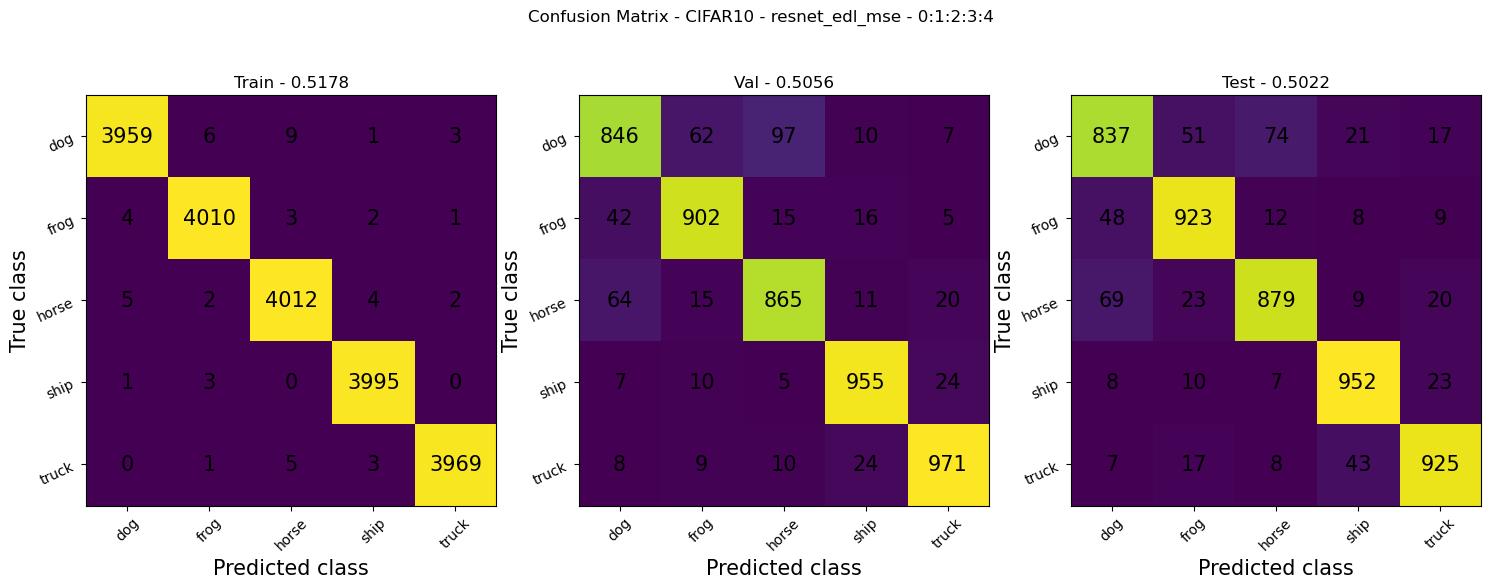

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5000, 2) (30000, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5000, 2) (30000, 2)


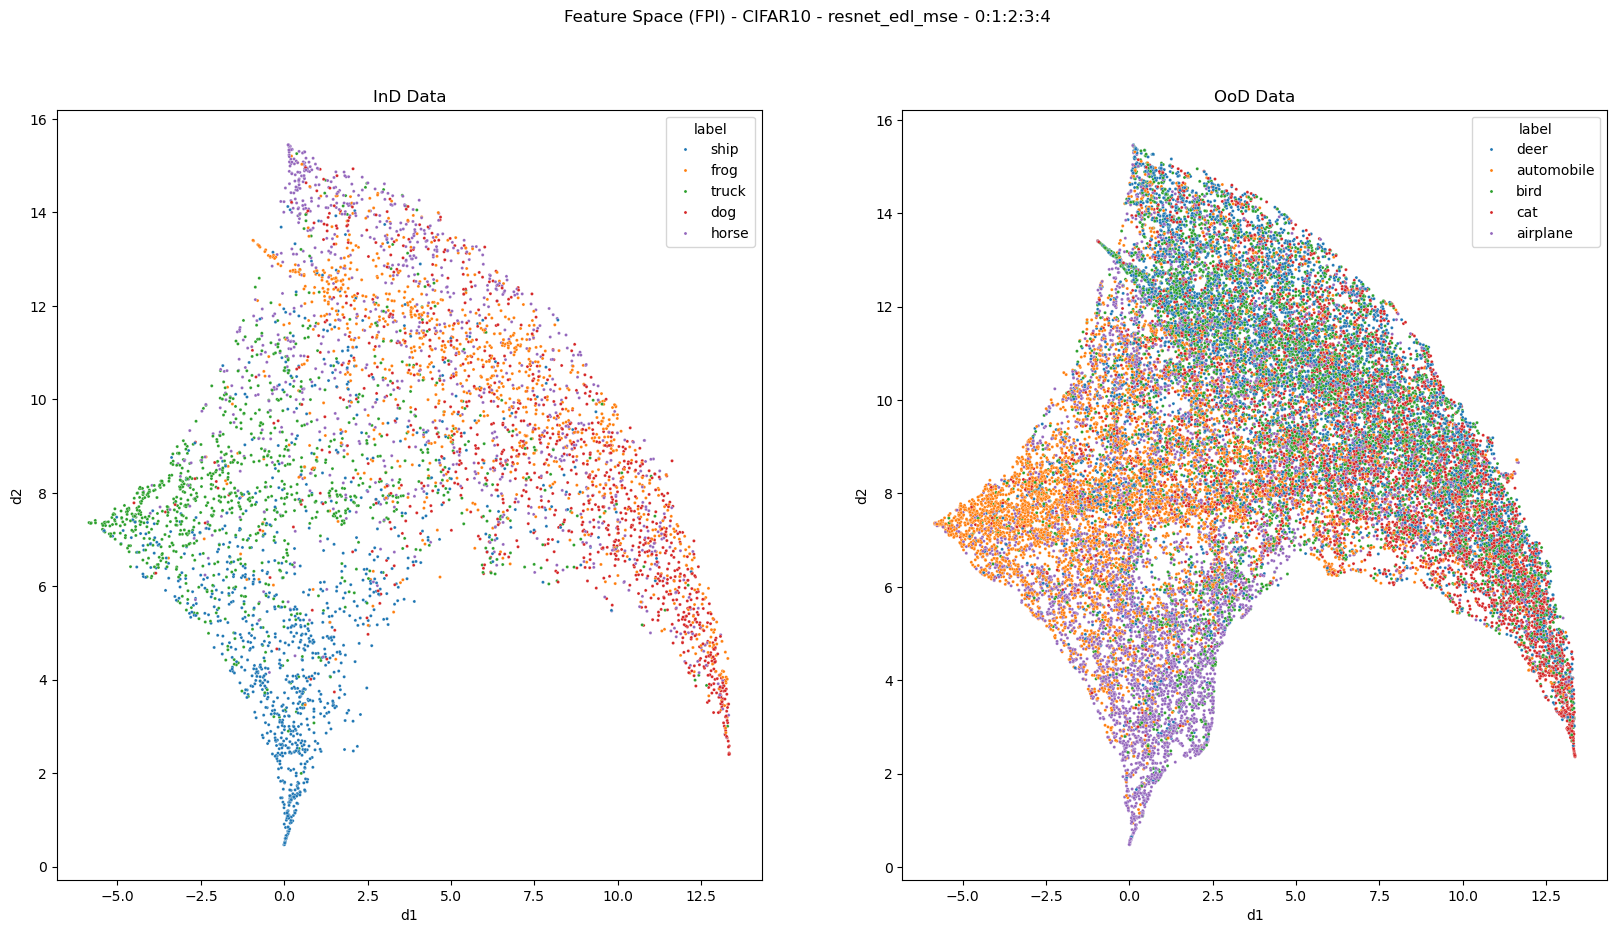

In [13]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

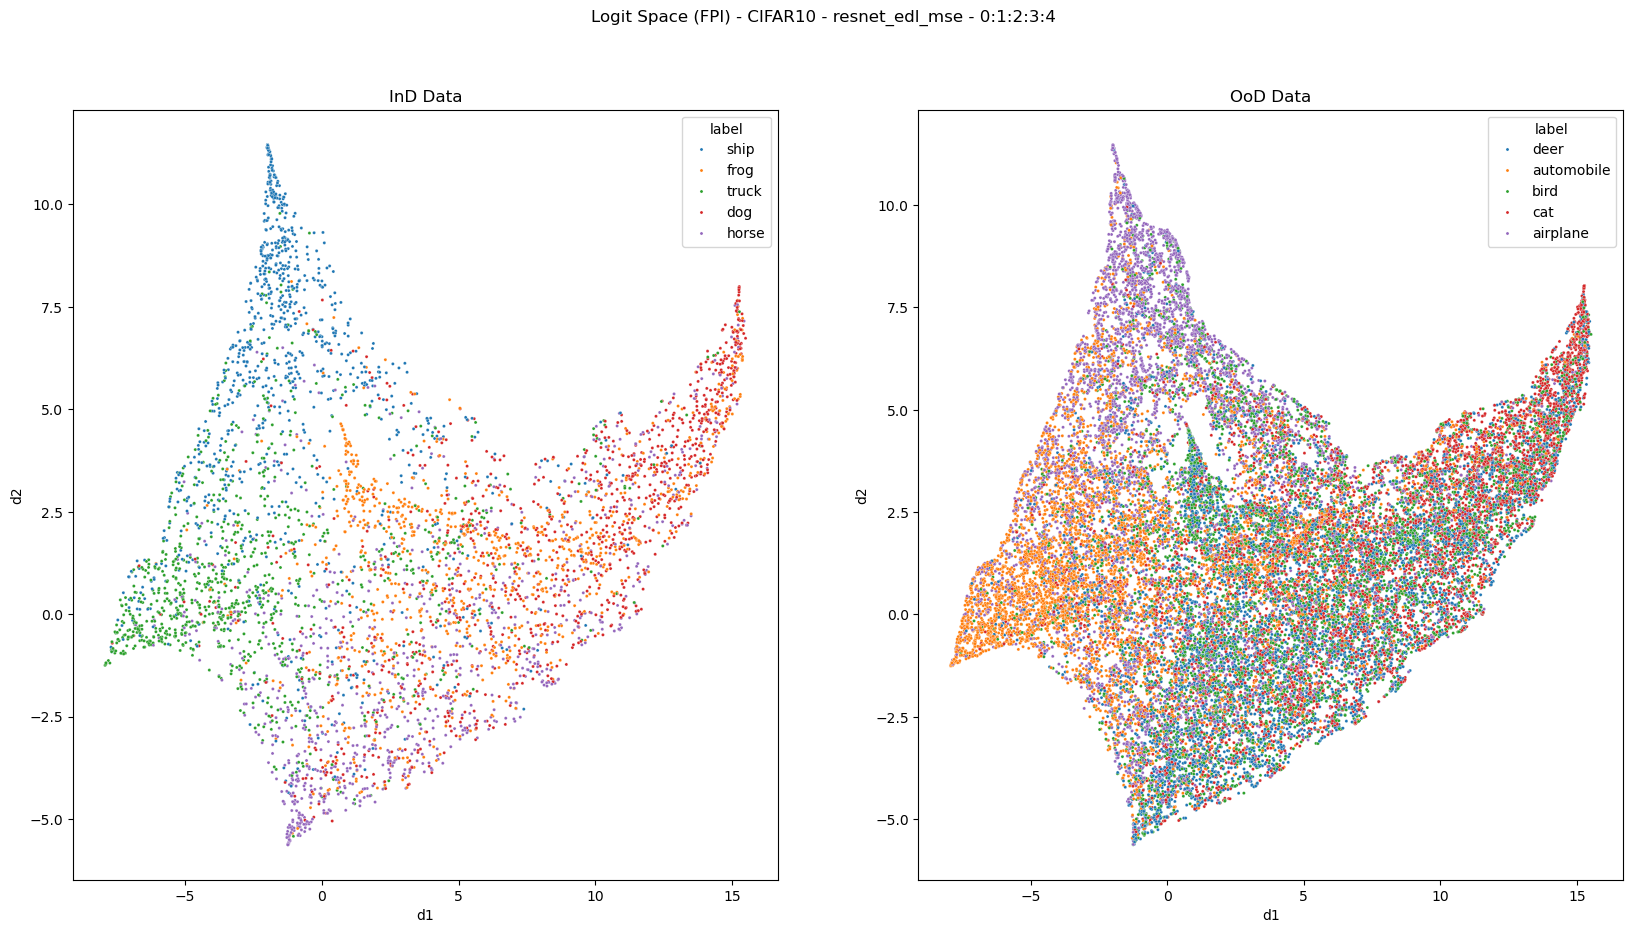

In [14]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

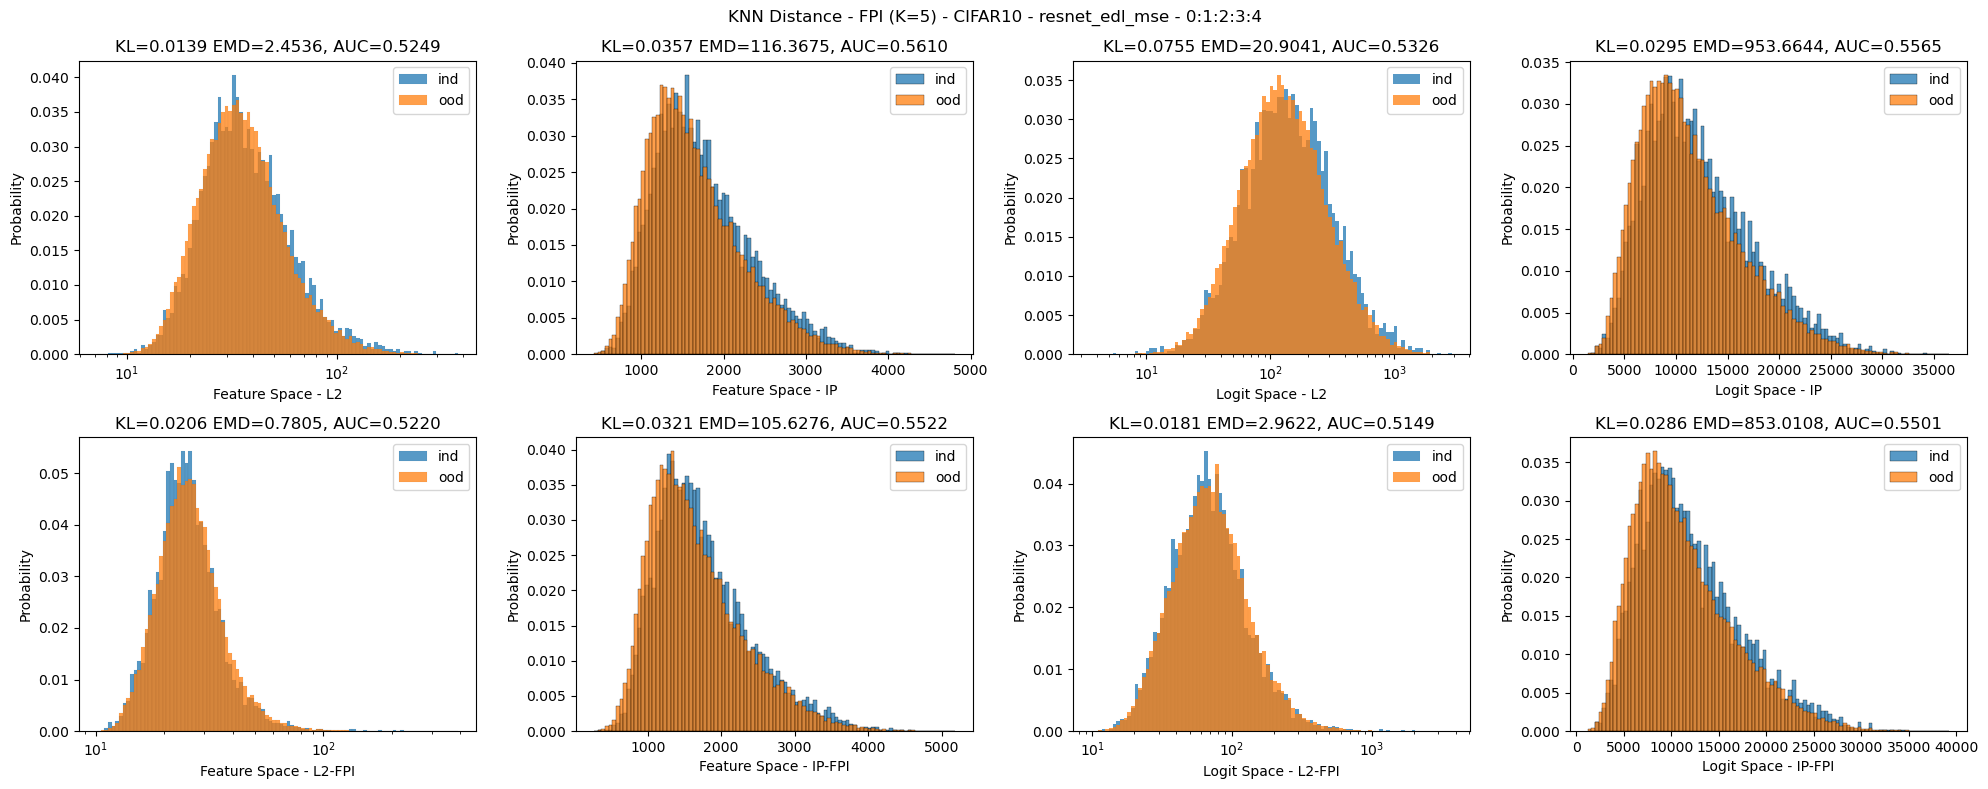

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig.suptitle(f"KNN Distance - FPI (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0][0], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[0][0].set_xlabel("Feature Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][1], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[0][1].set_xlabel("Feature Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[0][2], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[0][2].set_xlabel("Logit Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][3], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[0][3].set_xlabel("Logit Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[1][0], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[1][0].set_xlabel("Feature Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][1], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[1][1].set_xlabel("Feature Space - IP-FPI")
plot_knn_dists(faiss.IndexFlatL2, axs[1][2], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[1][2].set_xlabel("Logit Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][3], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[1][3].set_xlabel("Logit Space - IP-FPI")
plt.tight_layout()
plt.show()

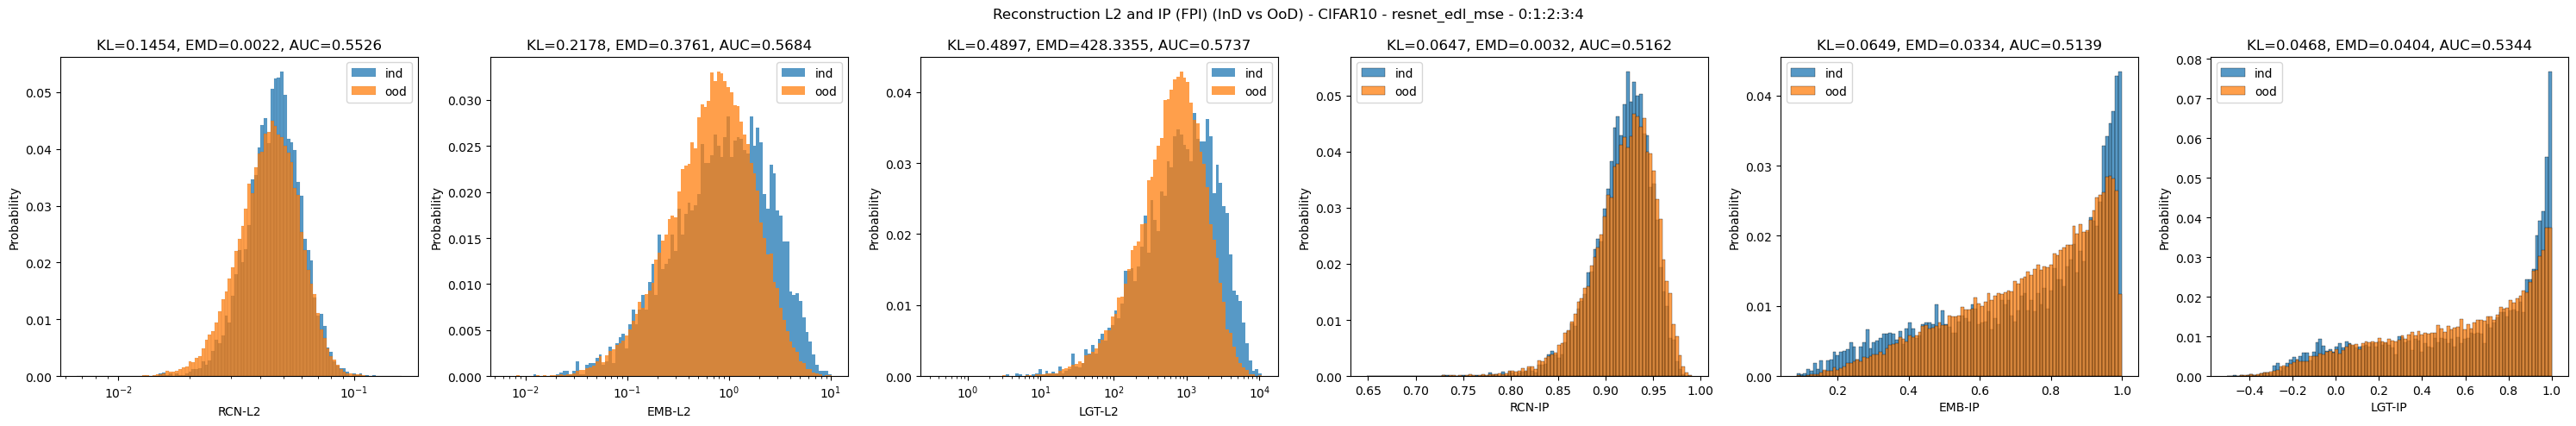

In [16]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
# unit vectors
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    # unit vectors
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
plot_rcn(ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
plot_rcn(ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
plot_rcn(ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
plot_rcn(ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
plot_rcn(ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

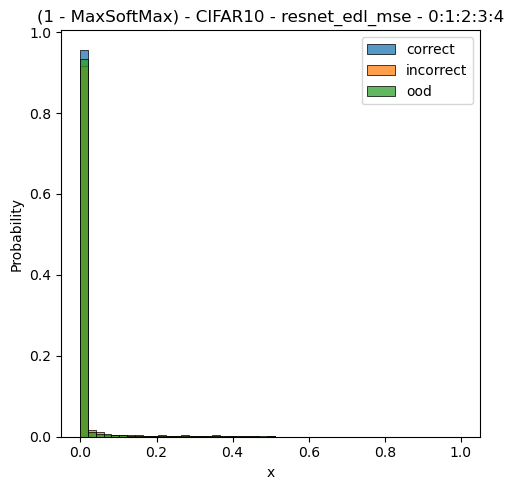

In [17]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

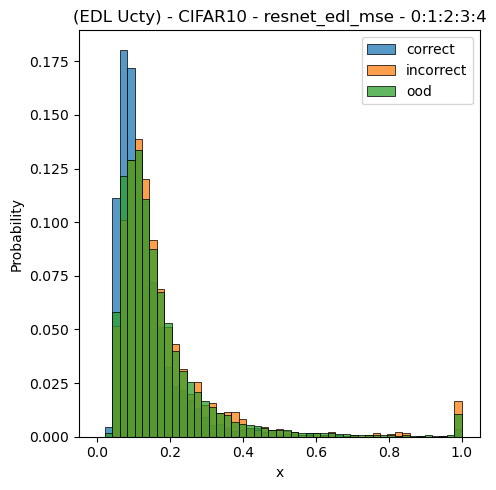

In [18]:
# plot (EDL uncertainty) of correct-ind, incorrect-ind, and ood data
K = ind_lgt_fpi.shape[-1]
ind_belief_fpi = np.clip(ind_lgt_fpi, 0, None)
ind_pred_fpi = ind_lgt_fpi.argmax(-1)
ind_prob_fpi = ind_belief_fpi / (ind_belief_fpi.sum(-1, keepdims=True) + K)
ind_ucty_fpi = K / (ind_belief_fpi.sum(-1) + K)

if ood_str:
    ood_belief_fpi = np.clip(ood_lgt_fpi, 0, None)
    ood_pred_fpi = ood_lgt_fpi.argmax(-1)
    ood_prob_fpi = ood_belief_fpi / (ood_belief_fpi.sum(-1, keepdims=True) + K)
    ood_ucty_fpi = K / (ood_belief_fpi.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()